# GINs with attention

In [3]:
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We'll train GIN on the _PROTEINS_ dataset.

In [39]:
dataset = TUDataset(root='.', name='NCI1').shuffle()

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {dataset[0].x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: NCI1(4110)
-------------------
Number of graphs: 4110
Number of nodes: 51
Number of features: 37
Number of classes: 2


We use mini-batching as it's very effective.

In [40]:
from torch_geometric.loader import DataLoader

# Create training, validation, and test sets
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset   = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset  = dataset[int(len(dataset)*0.9):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Validation set = {len(val_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nValidation loader:')
for i, subgraph in enumerate(val_loader):
    print(f' - Subgraph {i}: {subgraph}')

print('\nTest loader:')
for i, subgraph in enumerate(test_loader):
    print(f' - Subgraph {i}: {subgraph}')

Training set   = 3288 graphs
Validation set = 411 graphs
Test set       = 411 graphs

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 4384], x=[2017, 37], y=[64], batch=[2017], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 3888], x=[1803, 37], y=[64], batch=[1803], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 4064], x=[1861, 37], y=[64], batch=[1861], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 4052], x=[1885, 37], y=[64], batch=[1885], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 4364], x=[1999, 37], y=[64], batch=[1999], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 3882], x=[1795, 37], y=[64], batch=[1795], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 3928], x=[1812, 37], y=[64], batch=[1812], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 3956], x=[1813, 37], y=[64], batch=[1813], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 3754], x=[1750, 37], y=[64], batch=[1750], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 4028], x=[1857, 37], y=

We build GIN architecture as it's introduced in the paper "How powerful are Graph Neural Networks?". We also add an attention.

In [41]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, SAGPooling
from torch_geometric.nn import global_mean_pool, global_add_pool

class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.pool1 = SAGPooling(dim_h, min_score=0.001, GNN=GCNConv) # Self-attention layer
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.pool2 = SAGPooling(dim_h, min_score=0.001, GNN=GCNConv)
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.pool3 = SAGPooling(dim_h, min_score=0.001, GNN=GCNConv)
        self.conv4 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.pool4 = SAGPooling(dim_h, min_score=0.001, GNN=GCNConv)
        self.conv5 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h, F.log_softmax(h, dim=1)

gin = GIN(dim_h=32)

**Training**

In [42]:
loss_list = []

def train(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                      lr=0.01,
                                      weight_decay=0.01)
    epochs = 300

    model.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for data in loader:
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, val_acc = test(model, val_loader)

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
                f'| Train Acc: {acc*100:>5.2f}% '
                f'| Val Loss: {val_loss:.2f} '
                f'| Val Acc: {val_acc*100:.2f}%')
            
      test_loss, test_acc = test(model, test_loader)
      loss_list.append(test_loss)

      print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')
    
    return model

def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
      _, out = model(data.x, data.edge_index, data.batch)
      loss += criterion(out, data.y) / len(loader)
      acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

gin = train(gin, train_loader)

Epoch   0 | Train Loss: 0.72 | Train Acc: 54.40% | Val Loss: 0.69 | Val Acc: 50.02%
Test Loss: 0.69 | Test Acc: 53.94%
Test Loss: 0.65 | Test Acc: 61.43%
Test Loss: 0.64 | Test Acc: 60.25%
Test Loss: 0.64 | Test Acc: 62.93%
Test Loss: 0.65 | Test Acc: 60.92%
Test Loss: 0.64 | Test Acc: 60.90%
Test Loss: 0.64 | Test Acc: 63.60%
Test Loss: 0.63 | Test Acc: 61.90%
Test Loss: 0.64 | Test Acc: 63.15%
Test Loss: 0.63 | Test Acc: 62.93%
Epoch  10 | Train Loss: 0.62 | Train Acc: 66.09% | Val Loss: 0.61 | Val Acc: 64.58%
Test Loss: 0.64 | Test Acc: 63.15%
Test Loss: 0.63 | Test Acc: 64.27%
Test Loss: 0.62 | Test Acc: 65.24%
Test Loss: 0.61 | Test Acc: 64.27%
Test Loss: 0.63 | Test Acc: 64.94%
Test Loss: 0.64 | Test Acc: 63.29%
Test Loss: 0.62 | Test Acc: 64.94%
Test Loss: 0.61 | Test Acc: 66.72%
Test Loss: 0.61 | Test Acc: 65.77%
Test Loss: 0.63 | Test Acc: 62.54%
Epoch  20 | Train Loss: 0.60 | Train Acc: 68.23% | Val Loss: 0.59 | Val Acc: 67.20%
Test Loss: 0.61 | Test Acc: 66.36%
Test Loss: 0.

We save the model.

In [33]:
torch.save(gin.state_dict(), "C:/Users/patry/OneDrive/Pulpit/Studia_II_stopien/Uczenie_maszynowe/Projekt/models/nci1_attention.h5")

We save values of the loss to txt file.

In [43]:
loss_list = [float(x) for x in loss_list]

np.savetxt("C:/Users/patry/OneDrive/Pulpit/Studia_II_stopien/Uczenie_maszynowe/Projekt/Loss_values/NCI1_with_attention.txt", loss_list)

We plot values of the averaged loss function.

In [44]:
def moving_average(x: list, window_size = 10) -> list:
    
    return pd.Series(x).rolling(window=window_size).mean().iloc[window_size-1:].values

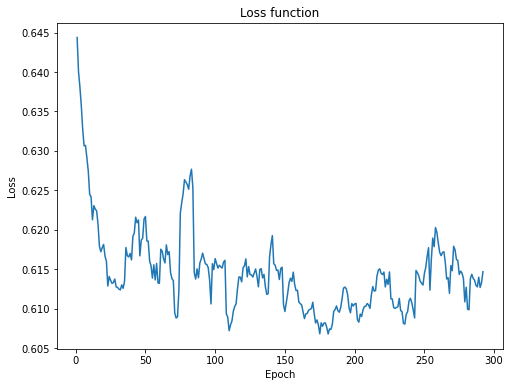

In [46]:
y = moving_average(loss_list)
x = [i for i in range(1, len(y) + 1)]

plt.figure(figsize = (8,6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function")
plt.plot(x, y)
plt.show()